In [4]:
import cohere
import os
from dotenv import load_dotenv
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
load_dotenv(dotenv_path='.env')

True

In [6]:
# COHERE_API_KEY
co = cohere.Client(api_key=os.getenv('COHERE_API_KEY'))

In [7]:
# load data from csv
df = pd.read_csv('comments.csv')

In [8]:
df = df.dropna()

In [9]:
# remove non-english characters
# df['comments'] = df['comments'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df.head(5)

,Unnamed: 0,comments
0,0,You can't stop dancing when you hear this song...
1,1,"Bruno Mars is one of the top pop musicians, gr..."
2,2,Yo todos los días la escucho
3,3,Listening and dancing!!!
4,4,10 years and this music will never be forgotten


In [10]:
comments = df['comments'].tolist()
comments[:5]

["You can't stop dancing when you hear this song. After 9 years, it's still my favorite. I love Bruno Mars. He is one of the most talented artists of all time.",
 'Bruno Mars is one of the top pop musicians, great song.',
 'Yo todos los días la escucho ',
 'Listening and dancing!!!',
 '10 years and this music will never be forgotten ',
 'You ever get into a mood at 2:50am and this song just hits different and you can listen to it 20 times',
 'Can’t believe this was a decade ago and it’s still as good as when it dropped. This man is still one of the best entertainers of this era and will go down a legend.',
 'Wow!!! Still LOVE it. So uplifting, yea!️',
 'The urge to dance is irresistible when this song plays. Even after 9 years, it remains my favorite. Bruno Mars is truly one of the most talented artists of all time.',
 'I love this so much when I’m in the car with my mum I play this all the time bc she loves it so much :)',
 'Muito  bom  esse música',
 "I'm I the only one who thinks th

In [11]:
# from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer
# from langdetect import detect

# def translate_text(text):
#   src_language = detect(text)
  
#   if src_language == "en":
#     return text
  
#   model_name = "facebook/m2m100_418M"
#   tokenizer = M2M100Tokenizer.from_pretrained(model_name)
#   model = M2M100ForConditionalGeneration.from_pretrained(model_name)

#   tokenizer.src_lang = src_language
#   encoded = tokenizer(text, return_tensors="pt")
  
#   generated_tokens = model.generate(**encoded, forced_bos_token_id=tokenizer.get_lang_id("en"))
  
#   return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

# # example usage
# text = "Bonjour, comment ça va?"
# translated_text = translate_text(text)
# print(translated_text)

In [12]:
# # translated_comments = [translate_text(comment) for comment in comments]
# def batch_translate_text(texts):
#   translated_texts = []
#   for text in texts:
#     try:
#       translated_texts.append(translate_text(text))
#     except Exception as e:
#       print(f"Failed to translate text: {text}")
#       translated_texts.append(text)
#   return translated_texts

# translated_comments = batch_translate_text(comments)
# translated_comments

In [31]:
from easynmt import EasyNMT
model = EasyNMT('m2m_100_418M')
# sentences = comments
# print(model.translate('Muito boa essa música', target_lang='en'))
# print(comments[10])

# translated_comments = batch_translate_text(comments)
# translated_comments

In [32]:
def batch_translate_text(texts, size=100, limit=1000):
  translated_texts = []
  for i in range(0, min(len(texts), limit), size):
    batch = texts[i:i+size]
    translated_batch = model.translate(batch, target_lang='en')
    translated_texts.extend(translated_batch)
  return translated_texts

In [33]:
translated_comments = batch_translate_text(comments, size=10, limit=200)
translated_comments[:5]

["You can't stop dancing when you hear this song. After 9 years, it's still my favorite. I love Bruno Mars. He is one of the most talented artists of all time.",
 'Bruno Mars is one of the top pop musicians, great song.',
 'I hear her every day. ',
 'Listening and dancing!!!',
 '10 years and this music will never be forgotten ']

: 

In [10]:
def batch_embed(texts, batch_size=100):
  responses = []
  for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    response = co.embed(
      texts=batch,
      model='embed-english-v3.0',
      input_type='clustering'
    )
    responses.extend(response)
  return responses

In [11]:
# # response = process_in_batches(comments)
# response = co.embed(
#   texts=translated_comments,
#   model='embed-english-v3.0',
#   input_type='clustering'
# )

In [12]:
from transformers import AutoModel, AutoTokenizer
import torch

def embed(comments):
  tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/RoBERTa-base-nli-stsb-mean-tokens")
  model = AutoModel.from_pretrained("sentence-transformers/RoBERTa-base-nli-stsb-mean-tokens")

  response = []
  for text in df.comments:
    tokens = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor([tokens])

    with torch.no_grad():
      outputs = model(input_ids)
      last_hidden_states = outputs.last_hidden_state

    sentence_embedding = torch.mean(last_hidden_states, dim=1).squeeze()
    response.append(sentence_embedding)

  return np.array(response)

In [13]:
response = embed(translated_comments)

In [41]:
embeddings = pd.DataFrame(response)
embeddings.to_csv('embed.csv', index=False)
embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.313366,-0.240415,-0.254093,-0.682217,0.957486,0.063650,-0.482229,-0.717610,0.352762,-0.648848,...,0.087191,-0.117713,-0.201095,-0.246845,-0.501250,0.013668,0.425081,-0.390780,0.076126,-0.069730
1,0.294601,-0.242065,-0.084323,-0.032529,0.230798,-0.134266,-0.516807,-0.006413,-0.178141,-0.338237,...,-0.373877,0.007750,-0.846110,-0.231706,0.133918,0.301326,0.486002,0.753464,0.088327,0.152819
2,0.558817,0.279325,-0.091237,0.235002,0.122414,0.344344,0.510071,-0.518477,1.161887,-0.147319,...,-1.874518,-0.458162,0.260443,-0.561178,0.564816,0.159017,-1.466355,-1.012565,0.323950,-0.528712
3,-0.004143,-0.242180,0.896928,0.984686,0.460831,0.829283,0.208562,-0.199537,-1.234848,0.462467,...,-0.383264,0.459393,-0.935413,0.869628,-0.571423,0.192255,0.005688,-1.399736,1.100822,0.945026
4,0.272800,-0.485158,-0.295244,-0.141509,0.099997,0.268509,-0.949785,-1.007874,0.141488,0.196811,...,0.300208,0.314172,0.829278,0.169454,-0.846630,0.488188,-1.224142,-0.002118,0.112006,0.106386


In [43]:
embeddings = pd.read_csv('embed.csv')

X = np.array(embeddings)
X

array([[ 0.31336585, -0.24041511, -0.25409266, ..., -0.3907796 ,
         0.0761258 , -0.06973036],
       [ 0.29460058, -0.24206479, -0.08432329, ...,  0.7534643 ,
         0.08832724,  0.15281916],
       [ 0.55881673,  0.2793248 , -0.09123728, ..., -1.0125655 ,
         0.32395008, -0.52871233],
       ...,
       [ 1.3180841 , -1.3514942 , -0.21679121, ...,  0.8927109 ,
         0.7695157 , -1.1904    ],
       [ 0.2065652 , -0.18318345, -0.48140177, ..., -0.05838976,
         0.08464316,  0.4457942 ],
       [ 0.36428508, -0.69097376, -0.16412097, ...,  0.4136827 ,
         0.14520589,  0.6913654 ]])

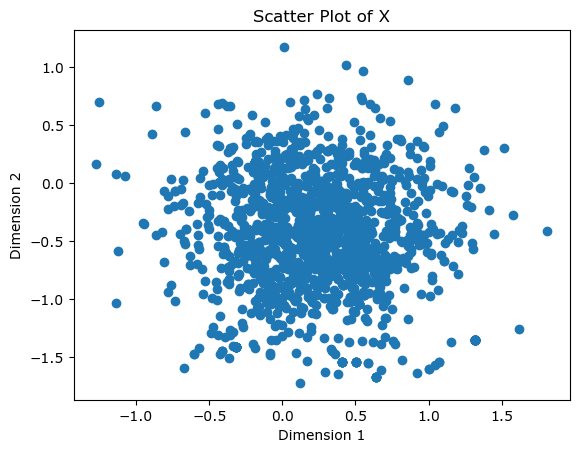

In [44]:
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot of X')
plt.show()

In [45]:
# cluster results
cluster = KMeans(n_clusters=10, random_state=0).fit(X)
# cluster = DBSCAN(eps=0.5, min_samples=5).fit(X)
# cluster = AffinityPropagation(random_state=42)
cluster_labels = cluster.fit_predict(X)
cluster_labels

c:\Users\ericz\miniconda3\envs\cc\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ericz\miniconda3\envs\cc\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ericz\miniconda3\envs\cc\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
c:\Users\ericz\miniconda3\envs\cc\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks t

array([9, 9, 3, ..., 7, 3, 1])

In [46]:
# find centroid of each cluster
centroids = cluster.cluster_centers_
# find original comment of each centroid
# centroid_comments = []
# for centroid in centroids:
#   print(np.where(X == centroid))
#   # print(comments[np.where(X == centroid)])
#   # centroid_comments.append(comments[np.where((X == centroid).all(axis=1))])
# centroid_comments
(X == centroids[0]).any(axis=1)
centroids.shape, X.shape

((10, 768), (1464, 768))

In [47]:
df['cluster'] = cluster_labels

In [48]:
df.groupby('cluster').count()

,Unnamed: 0,comments
cluster,,
0,197,197
1,128,128
2,195,195
3,257,257
4,19,19
5,183,183
6,168,168
7,70,70
8,103,103


In [49]:
for i in range(len(df.cluster.unique())):
  print('Cluster {}:'.format(i))
  print(df.loc[df['cluster'] == i, 'comments'])
  print()

Cluster 0:
4        10 years and this music will never be forgotten 
5       You ever get into a mood at 250am and this son...
12      This music is an emotional journey I can feel ...
15      This is a song that sounds like it couldve cam...
17                   I swear this song will NEVER get old
                              ...                        
1374    ok im done with this song thought i swear he s...
1409    Does Julia fabris still love this song amd Mic...
1420    I was trying to use the song with the real I w...
1474                  This song gets on my nerves already
1489    I do like the song but please Im begging you S...
Name: comments, Length: 197, dtype: object

Cluster 1:
75                       Its 2024 but this never gets old
127     Its 2024 \nabsolutely never stop listening thi...
137                   Casi ya 2024 y sigo con esta rolita
145     In 2024 partying like its 2015 Almost a decade...
167                           Whos here listening in 2024
      

In [50]:
# concatenate comments in each cluster into a single string
cluster_comments = []
for i in range(len(df.cluster.unique())):
  cluster_comments.append('\n'.join(df.loc[df['cluster'] == i, 'comments']))


In [19]:
import time

In [34]:
responses = []
for i in range(len(cluster_comments)):
  try:
    response = co.summarize(
        text=cluster_comments[i],
        model='command',
        length='short',
        extractiveness='medium'
    )
    response = "Summarized: " + response.summary
  except:
    response = "Original: " + cluster_comments[i]
  responses.append(response)
  # save to file
  with open('kmeans_summary.txt', 'a') as f:
    f.write('Cluster {}:'.format(i))
    f.write(response)
    f.write('\n\n')
  print()
  time.sleep(15) # "bypass" rate limit

In [20]:
# read kmeans summary

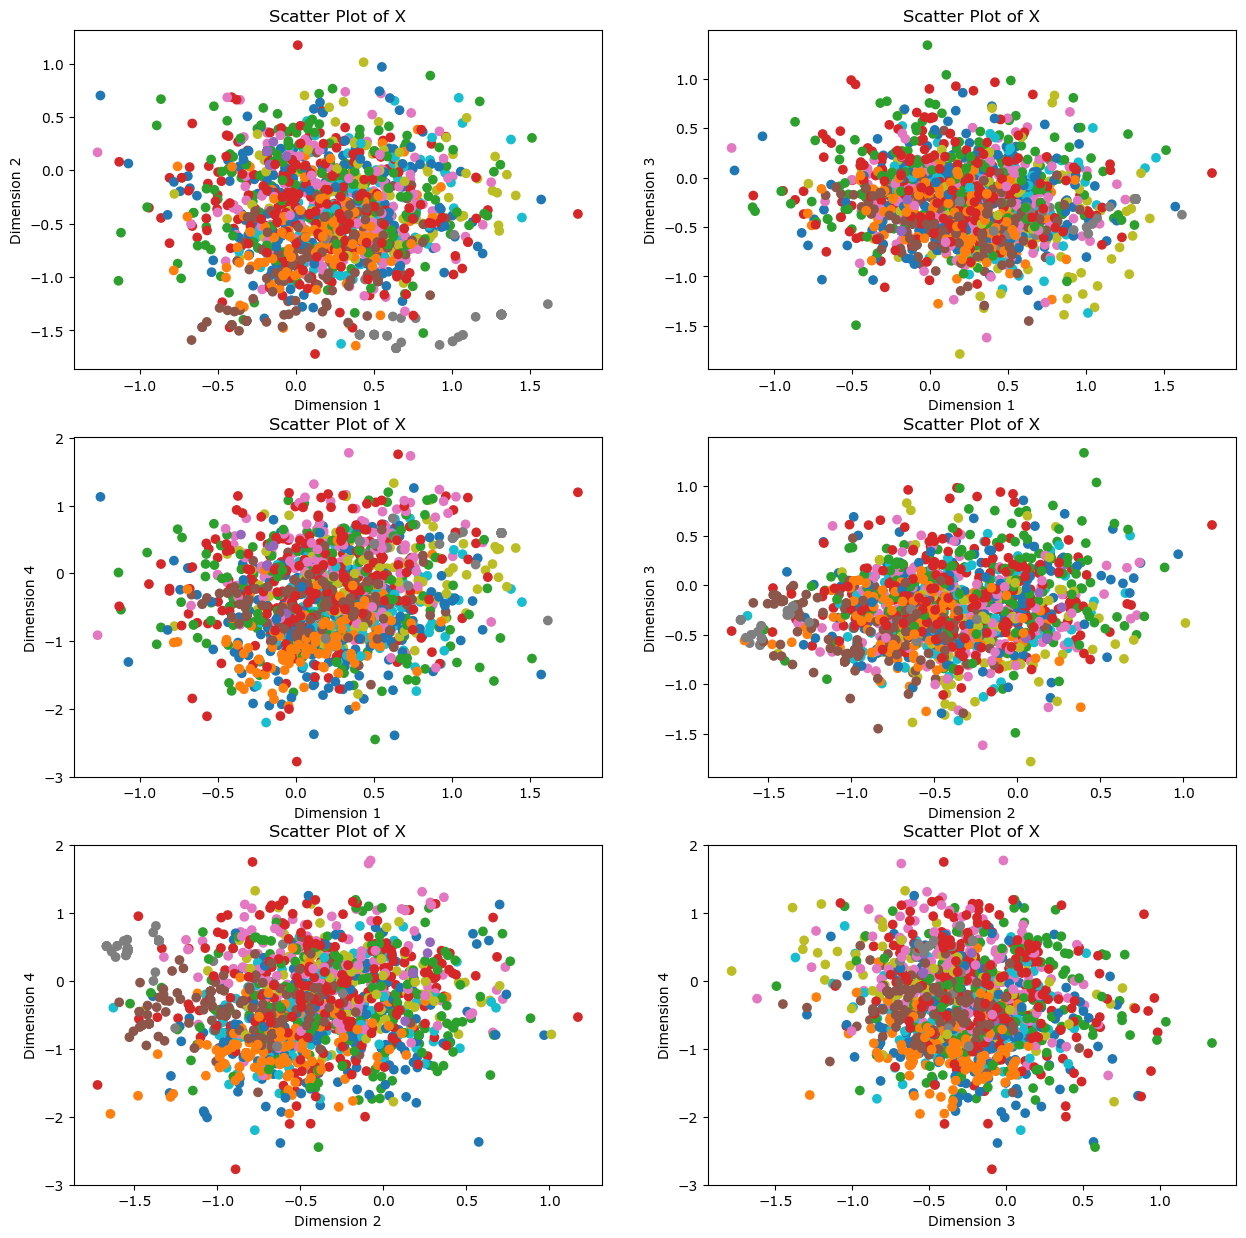

In [51]:
# plot the clusters with colors across different pairs of dimensions
from itertools import combinations

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for i, (x, y) in enumerate(combinations(range(4), 2)):
  ax = axes[i // 2, i % 2]
  ax.scatter(X[:, x], X[:, y], c=cluster_labels, cmap='tab10')
  ax.set_xlabel('Dimension {}'.format(x + 1))
  ax.set_ylabel('Dimension {}'.format(y + 1))
  ax.set_title('Scatter Plot of X')
plt.show()


In [52]:
# visualize in 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


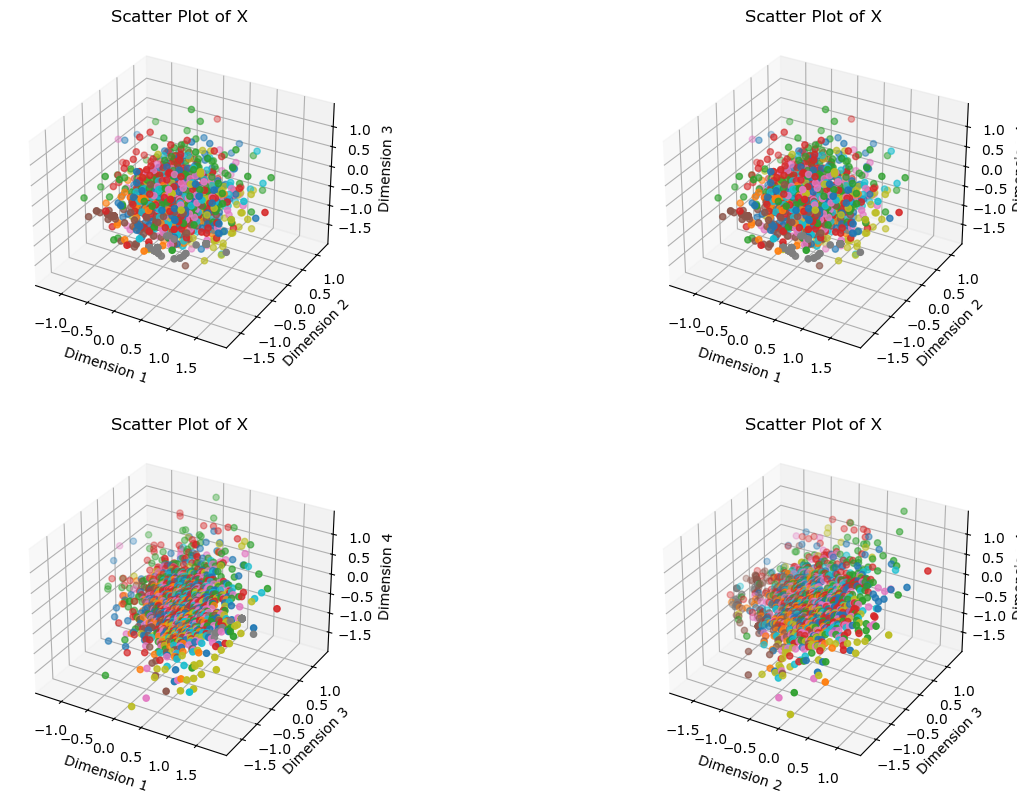

: 

In [53]:
from itertools import combinations
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=cluster_labels, cmap='tab10')
# ax.set_xlabel('Dimension 1')
# ax.set_ylabel('Dimension 2')
# ax.set_zlabel('Dimension 3')
# plt.show()

fig = plt.figure(figsize=(15, 15))
for i, (x, y, z) in enumerate(combinations(range(4), 3)):
  ax = fig.add_subplot(3, 2, i + 1, projection='3d')
  ax.scatter(X[:, x], X[:, y], X[:, 2], c=cluster_labels, cmap='tab10')
  ax.set_xlabel('Dimension {}'.format(x + 1))
  ax.set_ylabel('Dimension {}'.format(y + 1))
  ax.set_zlabel('Dimension {}'.format(z + 1))
  ax.set_title('Scatter Plot of X')
plt.show()
